In [1]:
# data
import pandas as pd
import numpy as np
from datetime import datetime
from math import ceil

# plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# MBA
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
pd.set_option('display.max_rows', 20)

## Exploration

In [4]:
df = pd.read_csv('retail.csv')

In [5]:
df_backup=df.copy()

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
df.groupby(['StockCode', 'Description'])['Quantity'].count()

StockCode     Description                        
10002         INFLATABLE POLITICAL GLOBE             71
10080         GROOVY CACTUS INFLATABLE               22
              check                                   1
10120         DOGGY RUBBER                           30
10123C        HEARTS WRAPPING TAPE                    3
                                                     ..
gift_0001_20  to push order througha s stock was      1
gift_0001_30  Dotcomgiftshop Gift Voucher £30.00      7
gift_0001_40  Dotcomgiftshop Gift Voucher £40.00      3
gift_0001_50  Dotcomgiftshop Gift Voucher £50.00      4
m             Manual                                  1
Name: Quantity, Length: 4792, dtype: int64

<AxesSubplot:xlabel='Description'>

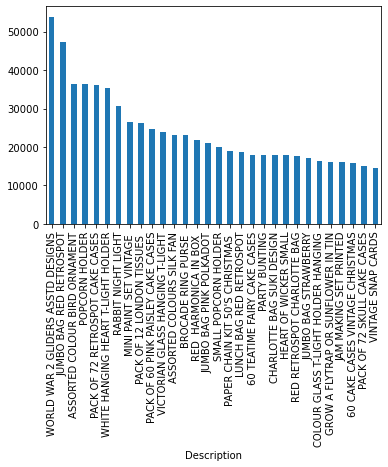

In [10]:
frequency = df.groupby('Description')['Quantity'].sum()
frequency = frequency.sort_values(ascending=False)
frequency[:30].plot(kind='bar')


In [11]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [12]:
#check for most profitable descriptions
profitable = df.groupby('Description')['TotalValue'].sum()
profitable = profitable.sort_values(ascending=False)
#profitable[:30].plot(kind='bar')


profitable

KeyError: 'Column not found: TotalValue'

## Processing

In [13]:
#lets look at the total profit of each item purchase
df['TotalValue'] = df['UnitPrice'] * df['Quantity']

#drop values where description is blank
df=df[df["Description"].isna()==False]

#we are only interested in relevent products, and some look non-relevent, so lets drop as many as we can
df['Description'] = df['Description'].str.lower()
df['StockCode'] = df['StockCode'].str.lower()

df=df[df['Description'].str.contains('amazon')==False]

df=df[df['UnitPrice']!=0]

C:\Users\renan\AppData\Local\Temp/ipykernel_4160/1337609512.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description'] = df['Description'].str.lower()
C:\Users\renan\AppData\Local\Temp/ipykernel_4160/1337609512.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StockCode'] = df['StockCode'].str.lower()


In [14]:
#now lets deal with the inconsistencies in the stock code and description
codes = df[['StockCode','Description']].drop_duplicates().groupby('StockCode').count()
duplicated_codes = codes.index[codes['Description']>1].to_numpy()

#Here is the list of inconsistent descriptions
df[['StockCode','Description',"UnitPrice"]].drop_duplicates()[df['StockCode'].isin(duplicated_codes)==True].sort_values("StockCode")

C:\Users\renan\AppData\Local\Temp/ipykernel_4160/1794222821.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[['StockCode','Description',"UnitPrice"]].drop_duplicates()[df['StockCode'].isin(duplicated_codes)==True].sort_values("StockCode")


,StockCode,Description,UnitPrice
47284,16156l,"wrap, carousel",0.42
138080,16156l,wrap carousel,0.42
6467,17107d,"flower fairy,5 summer b'draw liners",2.55
347764,17107d,flower fairy 5 summer draw liners,2.55
315743,17107d,flower fairy 5 drawer liners,2.55
...,...,...,...
10792,90014b,gold m pearl orbit necklace,10.62
89115,90014b,gold m pearl orbit necklace,10.40
504721,90014c,silver and black orbit necklace,2.95
501725,90014c,silver and black orbit necklace,10.40


In [15]:
#lets merge two tables, first table will be unique stock codes
df.groupby(["StockCode","Description"]).count().sort_values("StockCode")

,,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue
StockCode,Description,,,,,,,
10002,inflatable political globe,71,71,71,71,49,71,71
10080,groovy cactus inflatable,22,22,22,22,21,22,22
10120,doggy rubber,30,30,30,30,30,30,30
10123c,hearts wrapping tape,3,3,3,3,3,3,3
10124a,spots on red bookcover tape,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...
gift_0001_50,dotcomgiftshop gift voucher £50.00,4,4,4,4,0,4,4
m,manual,566,566,566,566,459,566,566
pads,pads to match all cushions,3,3,3,3,3,3,3


In [16]:
#finding the most common description for each stock code
desc_modes=df[["StockCode","Description"]].groupby(["StockCode"]).apply(pd.DataFrame.mode).reset_index(drop=True)

In [17]:
#sanity check - look at one that we know has multiple descriptions 
desc_modes[desc_modes["StockCode"]=="16156l"]

,StockCode,Description
42,16156l,wrap carousel


In [18]:
desc_modes.shape

(3830, 2)

In [19]:
#merging our new descriptions
df_merge = pd.merge(df, desc_modes, on ='StockCode', how ="left")

In [20]:
df=df_merge.drop('Description_x', axis=1).rename(columns = {'Description_y':'Description'})

In [21]:
#now dropping any products that are not products 
desc_to_drop = ["postage",'discount','manual','samples']
codes_do_drop = ['dot','m','d','s','b',"bank charges","cruk",'pads']

In [22]:
#df['Description'][df.Description.apply(len)<10].unique()
#df["StockCode"][df.StockCode.apply(len)<4].unique()

In [23]:
df=df[df["StockCode"].isin(codes_do_drop)==False]
df=df[df["Description"].isin(desc_to_drop)==False]

In [24]:
df.replace({"EIRE":"Ireland"}, inplace=True)

<AxesSubplot:>

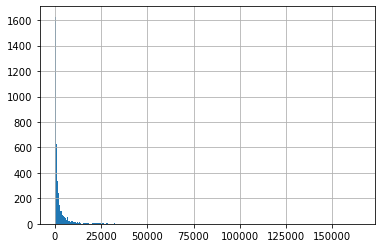

In [25]:
#now lets drop products that do not have enough value
# looking at the total sum value of each product, lets drop the products that did not reach a certain threshold
df[["StockCode","Description","TotalValue"]].groupby('StockCode')['TotalValue'].sum().hist(bins=300)

In [26]:
prodvalue=df[["StockCode","Description","TotalValue"]].groupby('StockCode')['TotalValue'].sum().sort_values().to_frame()
tv = prodvalue["TotalValue"].sum()

In [27]:
#lets make our arbitrary cutoff 300 over a 2 year period
prodvalue = prodvalue[prodvalue["TotalValue"]>=300]

In [28]:
ntv = prodvalue["TotalValue"].sum()
#by removing the products below the set threshold, we have removed only a small proportion of revenue (less than 2%)
(tv-ntv)/tv

0.01241738090074118

In [29]:
#but have reduced our item list by a lot, could be readjusted based on the scarcity of our matrix
prodvalue.shape

(2489, 1)

In [30]:
high_prof_codes = prodvalue.index.to_numpy()

#reduced dataframe
df=df[df['StockCode'].isin(high_prof_codes)==True]

In [31]:
#checkpoint 2
df_backup2=df.copy()

In [32]:
df.to_csv('cleaned_data2.csv', index=False)

## Market Basket Analysis

In [52]:
df = pd.read_csv('cleaned_data2.csv')

df.drop('CustomerID', axis=1, inplace=True)

df

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,Country,TotalValue,Description
0,536365,85123a,6,12/1/2010 8:26,2.55,United Kingdom,15.30,white hanging heart t-light holder
1,536365,71053,6,12/1/2010 8:26,3.39,United Kingdom,20.34,white metal lantern
2,536365,84406b,8,12/1/2010 8:26,2.75,United Kingdom,22.00,cream cupid hearts coat hanger
3,536365,84029g,6,12/1/2010 8:26,3.39,United Kingdom,20.34,knitted union flag hot water bottle
4,536365,84029e,6,12/1/2010 8:26,3.39,United Kingdom,20.34,red woolly hottie white heart.
...,...,...,...,...,...,...,...,...
516523,581587,22613,12,12/9/2011 12:50,0.85,France,10.20,pack of 20 spaceboy napkins
516524,581587,22899,6,12/9/2011 12:50,2.10,France,12.60,children's apron dolly girl
516525,581587,23254,4,12/9/2011 12:50,4.15,France,16.60,childrens cutlery dolly girl
516526,581587,23255,4,12/9/2011 12:50,4.15,France,16.60,childrens cutlery circus parade


In [53]:
#Removing null values for the invoice column and removing all the returns 
#(we are solely interested in the purchase behaviours)

df['InvoiceNo'] = df['InvoiceNo'].astype('str')
transaction_data = df[~df['Quantity'] < 0]

#Checking the top 4 countries to analyse the transactions per country
transaction_data

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,Country,TotalValue,Description
0,536365,85123a,6,12/1/2010 8:26,2.55,United Kingdom,15.30,white hanging heart t-light holder
1,536365,71053,6,12/1/2010 8:26,3.39,United Kingdom,20.34,white metal lantern
2,536365,84406b,8,12/1/2010 8:26,2.75,United Kingdom,22.00,cream cupid hearts coat hanger
3,536365,84029g,6,12/1/2010 8:26,3.39,United Kingdom,20.34,knitted union flag hot water bottle
4,536365,84029e,6,12/1/2010 8:26,3.39,United Kingdom,20.34,red woolly hottie white heart.
...,...,...,...,...,...,...,...,...
516523,581587,22613,12,12/9/2011 12:50,0.85,France,10.20,pack of 20 spaceboy napkins
516524,581587,22899,6,12/9/2011 12:50,2.10,France,12.60,children's apron dolly girl
516525,581587,23254,4,12/9/2011 12:50,4.15,France,16.60,childrens cutlery dolly girl
516526,581587,23255,4,12/9/2011 12:50,4.15,France,16.60,childrens cutlery circus parade


In [54]:
# invoices from France
basket_fr = (transaction_data[transaction_data['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
 
# invoices from the United Kingdom
basket_uk = (transaction_data[transaction_data['Country'] =="United Kingdom"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
 
# Invoices from Germany
basket_de = (transaction_data[transaction_data['Country'] =="Germany"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
 
# Invoices from Ireland
basket_ie = (transaction_data[transaction_data['Country'] =="Ireland"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [55]:
# Defining the encoding function to make 0 or 1 for the variables purchased

def encode(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1
 
# Encoding the datasets

basket_encoded = basket_fr.applymap(encode)
basket_fr = basket_encoded
 
basket_encoded = basket_uk.applymap(encode)
basket_uk = basket_encoded
 
basket_encoded = basket_de.applymap(encode)
basket_de = basket_encoded
 
basket_encoded = basket_ie.applymap(encode)
basket_ie = basket_encoded

In [104]:
#Running the apriori algorithm for French basket - Complementary products
frq_items = apriori(basket_fr, min_support = 0.05, use_colnames = True)
 
# Create a dataframe with the rules
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
#rules.head()
#rules.to_csv('france.csv', index=False)

rules[ (rules['lift'] >= 7) & (rules['confidence'] >= 0.8) ].head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [57]:
#Substitute items French Basket
substitutes = association_rules(frq_items, metric="lift", min_threshold=0.0)
substitutes.sort_values(by='lift', ascending=True, inplace=True)
substitutes.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
57,(rabbit night light),(red toadstool led night light),0.194226,0.186352,0.055118,0.283784,1.522840,0.018924,1.136037
56,(red toadstool led night light),(rabbit night light),0.186352,0.194226,0.055118,0.295775,1.522840,0.018924,1.144199
48,(plasters in tin circus parade ),(red toadstool led night light),0.173228,0.186352,0.052493,0.303030,1.626120,0.020212,1.167408
49,(red toadstool led night light),(plasters in tin circus parade ),0.186352,0.173228,0.052493,0.281690,1.626120,0.020212,1.150996
55,(plasters in tin woodland animals),(red toadstool led night light),0.175853,0.186352,0.055118,0.313433,1.681942,0.022348,1.185096
54,(red toadstool led night light),(plasters in tin woodland animals),0.186352,0.175853,0.055118,0.295775,1.681942,0.022348,1.170289
50,(round snack boxes set of4 woodland ),(plasters in tin circus parade ),0.162730,0.173228,0.055118,0.338710,1.955279,0.026929,1.250240
51,(plasters in tin circus parade ),(round snack boxes set of4 woodland ),0.173228,0.162730,0.055118,0.318182,1.955279,0.026929,1.227997
46,(plasters in tin circus parade ),(red retrospot mini cases),0.173228,0.141732,0.052493,0.303030,2.138047,0.027941,1.231428
47,(red retrospot mini cases),(plasters in tin circus parade ),0.141732,0.173228,0.052493,0.370370,2.138047,0.027941,1.313108


In [105]:
#Do the same for the UK

frq_items = apriori(basket_uk, min_support = 0.015, use_colnames = True)
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
#rules.head()
#rules.to_csv('uk.csv', index=False)
rules[ (rules['lift'] >= 5) & (rules['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [59]:
#Substitute items UK Basket
substitutes = association_rules(frq_items, metric="lift", min_threshold=0.0)
substitutes.sort_values(by='lift', ascending=True, inplace=True)
substitutes.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
500,(regency cakestand 3 tier),(white hanging heart t-light holder),0.094472,0.121720,0.018894,0.200000,1.643114,0.007395,1.097850
501,(white hanging heart t-light holder),(regency cakestand 3 tier),0.121720,0.094472,0.018894,0.155228,1.643114,0.007395,1.071920
249,(jumbo bag red retrospot),(party bunting),0.108488,0.089314,0.017661,0.162791,1.822684,0.007971,1.087764
248,(party bunting),(jumbo bag red retrospot),0.089314,0.108488,0.017661,0.197740,1.822684,0.007971,1.111250
17,(white hanging heart t-light holder),(assorted colour bird ornament),0.121720,0.076867,0.017156,0.140949,1.833672,0.007800,1.074596
16,(assorted colour bird ornament),(white hanging heart t-light holder),0.076867,0.121720,0.017156,0.223195,1.833672,0.007800,1.130631
264,(jumbo bag red retrospot),(white hanging heart t-light holder),0.108488,0.121720,0.024557,0.226357,1.859648,0.011352,1.135252
265,(white hanging heart t-light holder),(jumbo bag red retrospot),0.121720,0.108488,0.024557,0.201750,1.859648,0.011352,1.116833
453,(white hanging heart t-light holder),(lunch bag suki design ),0.121720,0.067280,0.015250,0.125288,1.862196,0.007061,1.066317
452,(lunch bag suki design ),(white hanging heart t-light holder),0.067280,0.121720,0.015250,0.226667,1.862196,0.007061,1.135707


In [106]:
#Do the same for Germany

frq_items = apriori(basket_de, min_support = 0.05, use_colnames = True)
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
#rules.head()
#rules.to_csv('germany.csv', index=False)
rules[ (rules['lift'] >= 1.5) & (rules['confidence'] >= 0.6) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [61]:
#Substitute items German Basket
substitutes = association_rules(frq_items, metric="lift", min_threshold=0.0)
substitutes.sort_values(by='lift', ascending=True, inplace=True)
substitutes.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(plasters in tin circus parade ),(round snack boxes set of4 woodland ),0.119910,0.253394,0.058824,0.490566,1.935984,0.028439,1.465561
4,(round snack boxes set of4 woodland ),(plasters in tin circus parade ),0.253394,0.119910,0.058824,0.232143,1.935984,0.028439,1.146164
17,(woodland charlotte bag),(round snack boxes set of4 woodland ),0.131222,0.253394,0.065611,0.500000,1.973214,0.032360,1.493213
16,(round snack boxes set of4 woodland ),(woodland charlotte bag),0.253394,0.131222,0.065611,0.258929,1.973214,0.032360,1.172327
9,(plasters in tin woodland animals),(round snack boxes set of4 woodland ),0.142534,0.253394,0.076923,0.539683,2.129819,0.040806,1.621938
8,(round snack boxes set of4 woodland ),(plasters in tin woodland animals),0.253394,0.142534,0.076923,0.303571,2.129819,0.040806,1.231233
2,(plasters in tin circus parade ),(round snack boxes set of 4 fruits ),0.119910,0.162896,0.052036,0.433962,2.664046,0.032503,1.478884
3,(round snack boxes set of 4 fruits ),(plasters in tin circus parade ),0.162896,0.119910,0.052036,0.319444,2.664046,0.032503,1.293194
14,(round snack boxes set of4 woodland ),(spaceboy lunch box ),0.253394,0.106335,0.072398,0.285714,2.686930,0.045454,1.251131
15,(spaceboy lunch box ),(round snack boxes set of4 woodland ),0.106335,0.253394,0.072398,0.680851,2.686930,0.045454,2.339367


In [107]:
#Do the same for Ireland

frq_items = apriori(basket_ie, min_support = 0.05, use_colnames = True)
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
#rules.head()
#rules.to_csv('ireland.csv', index=False)
rules[ (rules['lift'] >= 10) & (rules['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [63]:
#Substitute items Irish Basket
substitutes = association_rules(frq_items, metric="lift", min_threshold=0.0)
substitutes.sort_values(by='lift', ascending=True, inplace=True)
substitutes.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(regency cakestand 3 tier),(carriage),0.246479,0.373239,0.059859,0.242857,0.650674,-0.032136,0.827797
3,(carriage),(regency cakestand 3 tier),0.373239,0.246479,0.059859,0.160377,0.650674,-0.032136,0.897452
4,(vintage snap cards),(carriage),0.154930,0.373239,0.052817,0.340909,0.913379,-0.005009,0.950947
5,(carriage),(vintage snap cards),0.373239,0.154930,0.052817,0.141509,0.913379,-0.005009,0.984368
50,(set of 3 regency cake tins),(regency cakestand 3 tier),0.123239,0.246479,0.070423,0.571429,2.318367,0.040047,1.758216
51,(regency cakestand 3 tier),(set of 3 regency cake tins),0.246479,0.123239,0.070423,0.285714,2.318367,0.040047,1.227465
49,(roses regency teacup and saucer ),(regency cakestand 3 tier),0.169014,0.246479,0.112676,0.666667,2.704762,0.071018,2.260563
48,(regency cakestand 3 tier),(roses regency teacup and saucer ),0.246479,0.169014,0.112676,0.457143,2.704762,0.071018,1.530764
9,(green regency teacup and saucer),(regency cakestand 3 tier),0.126761,0.246479,0.088028,0.694444,2.817460,0.056784,2.466069
8,(regency cakestand 3 tier),(green regency teacup and saucer),0.246479,0.126761,0.088028,0.357143,2.817460,0.056784,1.358372


- If the basket is "full", suggest something useful for that specific customer
- If the basket is "full" but the customer is unknown (guest) suggest a cold start product.